<a href="https://colab.research.google.com/github/Akechi1412/Sentiment-Analysis/blob/main/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Product Reviews**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
# !git clone https://github.com/Akechi1412/Sentiment-Analysis.git
%cd Sentiment-Analysis
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/.shortcut-targets-by-id/1s7C_pXybLyG2ZPrSW0ni6I01zFpbMZ8j/Sentiment-Analysis
Updating files: 100% (11/11), done.
HEAD is now at eba547d Update sentiment_analysis.ipynb


## **Data Collecting**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('data/data - data.csv')
print(df.head())

comments = df['comment'].values
labels = df['label'].values
print(len(comments), len(labels))

                       comment label  rate Unnamed: 3
0               Áo bao đẹp ạ!!   POS     5        NaN
1                  Tuyệt vời !   POS     5        NaN
2   2day ao khong giong trong.   NEG     1        NaN
3  Mùi thơm,bôi lên da mềm da.   POS     5        NaN
4            Vải đẹp, dày dặn.   POS     5        NaN
31460 31460


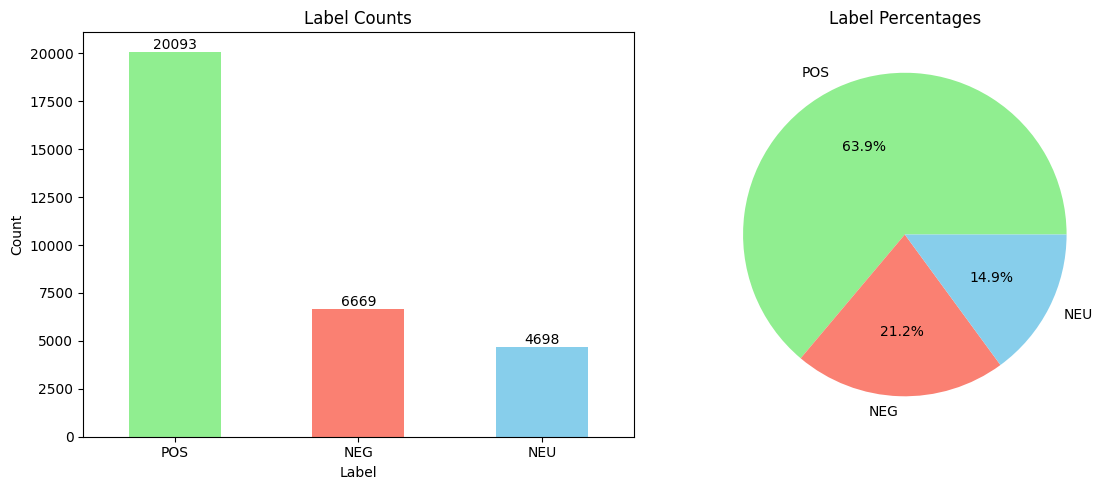

In [5]:
# Count the labels
label_counts = df['label'].value_counts()

# Calculate label percentages
label_percentages = label_counts / label_counts.sum() * 100

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Bar plot for label counts
plt.subplot(1, 2, 1)
bars = label_counts.plot(kind='bar', color=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add the exact count on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{int(bar.get_height())}',
             ha='center', va='bottom', color='black')

# Pie chart for label percentages
plt.subplot(1, 2, 2)
label_percentages.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Percentages')
plt.ylabel('')

plt.tight_layout()
plt.show()

## **Data preprocessing**

In [6]:
!pip install underthesea emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.6 MB/s eta 0:00:00


In [7]:
from utils.data_preprocessing import clean_text
import seaborn as sns
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
from transformers import AutoTokenizer
import tensorflow as tf

In [8]:
filtered_data = [(clean_text(comment), label)
    for comment, label in zip(comments, labels)
        if len(clean_text(comment)) > 1]
x_data, y_data = zip(*filtered_data)
x_data = list(x_data)
y_data = list(y_data)

print(len(x_data), len(y_data))

31358 31358


In [9]:
x_train, x_temp, y_train, y_temp \
    = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test \
    = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

25086 25086
3136 3136
3136 3136


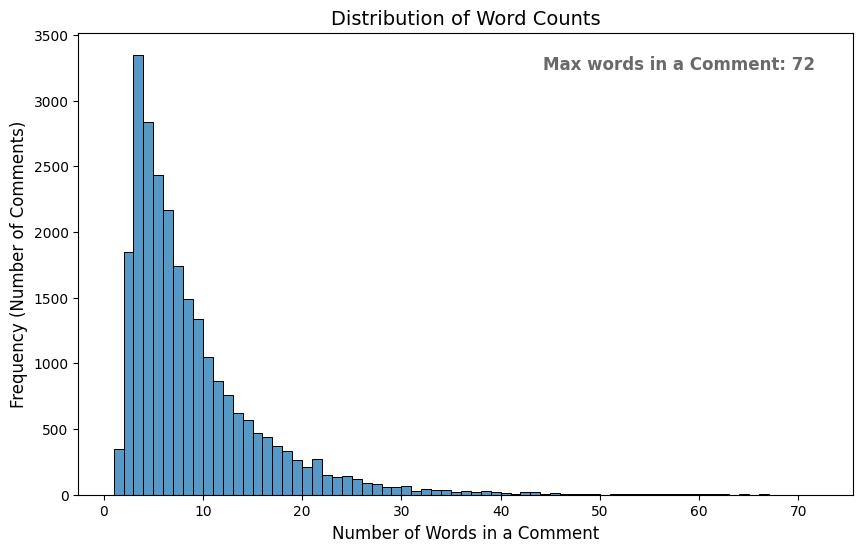

In [10]:
word_counts = [len(item.split()) for item in x_train]
max_word_count = max(word_counts)

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, max_word_count+1), kde=False)
plt.title('Distribution of Word Counts', fontsize=14)
plt.xlabel('Number of Words in a Comment', fontsize=12)
plt.ylabel('Frequency (Number of Comments)', fontsize=12)
plt.text(
    x=0.95, y=0.95,
    s=f'Max words in a Comment: {max_word_count}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

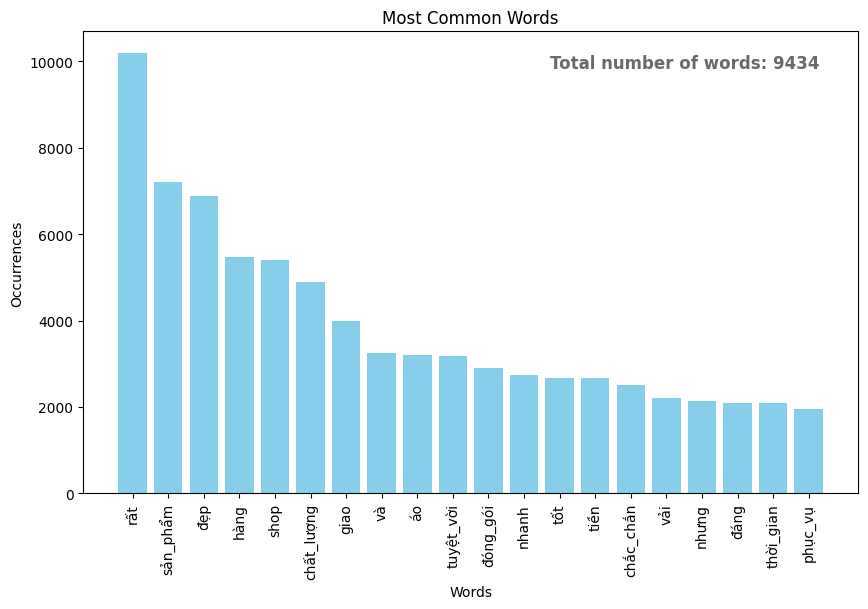

In [11]:
words = [word for comment in x_train for word in comment.split()]
word_counts = Counter(words)
most_common_words = Counter(words).most_common(20)
labels, values = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.title('Most Common Words')
plt.xticks(rotation=90)
plt.text(
    x=0.95, y=0.95, s=f'Total number of words: {len(word_counts)}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

In [12]:
# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 50
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

In [13]:
# Encode label
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate([y_train, y_val, y_test]))

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print('Label mapping:', label_mapping)

Label mapping: {'NEG': 0, 'NEU': 1, 'POS': 2}


## **Training**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, models, layers, regularizers, optimizers

In [15]:
# Input
input = layers.Input(shape=(max_len,))

# Embedding Layer
embedding_output = layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=100
)(input)

# BiLSTM Layer
lstm_output = layers.Bidirectional(
    layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
)(embedding_output)

# Global Average Pooling and Global Max Pooling
avg_pool = layers.GlobalAveragePooling1D()(lstm_output)
max_pool = layers.GlobalMaxPooling1D()(lstm_output)

# Concatenate Pooling Outputs
concat = layers.Concatenate()([avg_pool, max_pool])

# Fully Connected Layers
dense_1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(1e-6))(concat)
dropout_1 = layers.Dropout(0.3)(dense_1)
dense_2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(1e-6))(dropout_1)
dropout_2 = layers.Dropout(0.3)(dense_2)

# Output Layer
output = layers.Dense(3, activation='softmax')(dropout_2)

# Final Model
model = Model(inputs=input, outputs=output)

# Compile Model
optimizer = optimizers.Adam(learning_rate=1e-3)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 100)        │        483,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        262,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │          1,539 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,244,547 (4.75 MB)

 Trainable params: 1,244,547 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    x=x_train_pad,
    y=y_train_encoded,
    validation_data=(x_val_pad, y_val_encoded),
    batch_size=64,
    epochs=20,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7077 - loss: 0.7016
Epoch 1: val_loss improved from inf to 0.52123, saving model to models/best_model.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.7079 - loss: 0.7013 - val_accuracy: 0.7854 - val_loss: 0.5212
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8091 - loss: 0.4768
Epoch 2: val_loss improved from 0.52123 to 0.50373, saving model to models/best_model.keras
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.8091 - loss: 0.4768 - val_accuracy: 0.8023 - val_loss: 0.5037
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8305 - loss: 0.4291
Epoch 3: val_loss did not improve from 0.50373
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.8305 - loss: 0.4291 - val_accuracy: 0.7988 - val_loss: 0.5177
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8407 - loss: 0.4033
Epoch 4: val_loss did not improve from 0.50373
392/392 ━━━━━━━━━━━━━

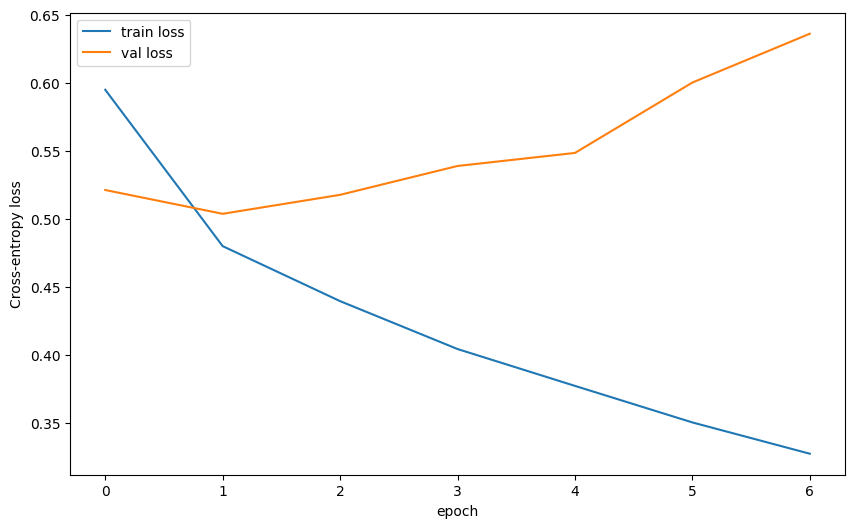

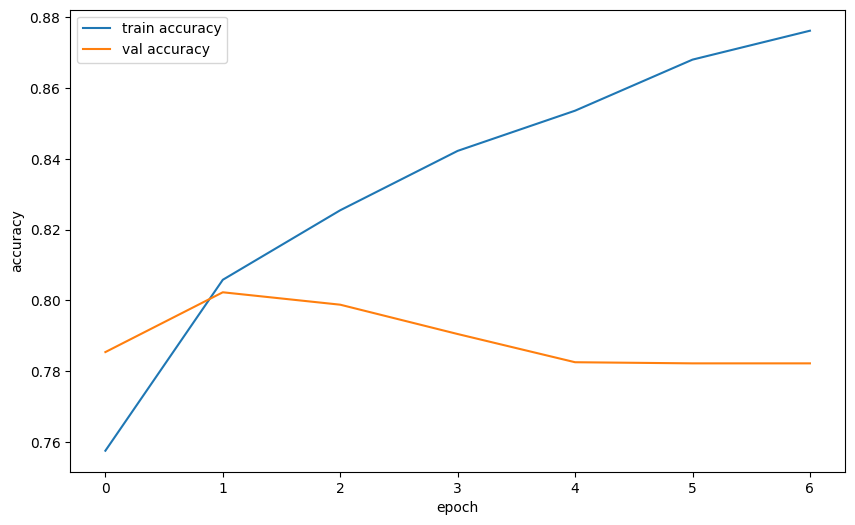

In [17]:
history = model.history

# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
model.save('models/best_model.h5')

## **Model Evaluation**

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
y_pred_prob = model.predict(x_test_pad)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
print(classification_report(y_test_encoded, y_pred, target_names=['NEG', 'NEU', 'POS']))

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
              precision    recall  f1-score   support

         NEG       0.70      0.84      0.76       675
         NEU       0.46      0.24      0.31       448
         POS       0.88      0.92      0.90      2013

    accuracy                           0.81      3136
   macro avg       0.68      0.67      0.66      3136
weighted avg       0.78      0.81      0.79      3136



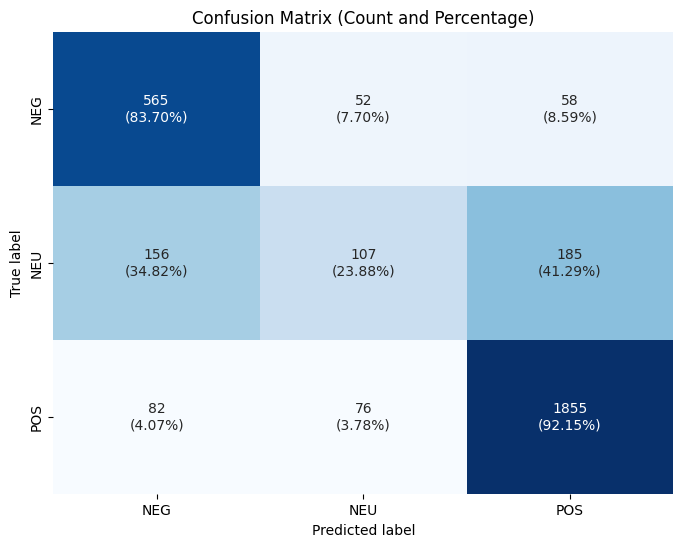

In [21]:
cm = confusion_matrix(y_test_encoded, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

formatted_labels = [
    [f'{int(count)}\n({percentage:.2%})' for count, percentage in zip(row_count, row_percentage)]
    for row_count, row_percentage in zip(cm, cm_percentage)
]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=formatted_labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()